# Data Imputation with Autoencoders

Autoencoders may be used for data imputation. Let's see how data imputation with autoencoder works.

## Data

The data is sampled as follows.

- $X_0 \sim \mathcal{N}(0, 1)$
- $X_1 \sim \mathcal{N}(1.1 + 4 X_0, 1)$
- $X_2 \sim \mathcal{N}(2.3 - 0.5 X_0, 1)$

In [1]:
import numpy as np
import random

np.random.seed(37)
random.seed(37)

size = 1_000

X_0 = np.random.normal(0, 1, size=size)
X_1 = 1.1 + 4 * X_0 + np.random.normal(0, 1, size=size)
X_2 = 2.3 - 0.5 * X_0 + np.random.normal(0, 1, size=size)

X = np.hstack([X_0.reshape(-1, 1), X_1.reshape(-1, 1), X_2.reshape(-1, 1)])

X.shape

(1000, 3)

## Missing data

We will make 10% of the data missing randomly.

In [2]:
import itertools
import pandas as pd

def make_missing(X, frac=0.1):
    n = int(frac * X.shape[0] * X.shape[1])
    
    rows = list(range(X.shape[0]))
    cols = list(range(X.shape[1]))
    
    coordinates = list(itertools.product(*[rows, cols]))
    random.shuffle(coordinates)
    coordinates = coordinates[:n]
        
    M = np.copy(X)
    
    for r, c in coordinates:
        M[r, c] = np.nan
            
    return pd.DataFrame(M, columns=[f'X_{i}' for i in range(X.shape[1])]), coordinates

df, coordinates = make_missing(X)

In [3]:
df.isna().sum()

X_0     99
X_1    102
X_2     99
dtype: int64

In [4]:
df.isna().sum().sum()

300

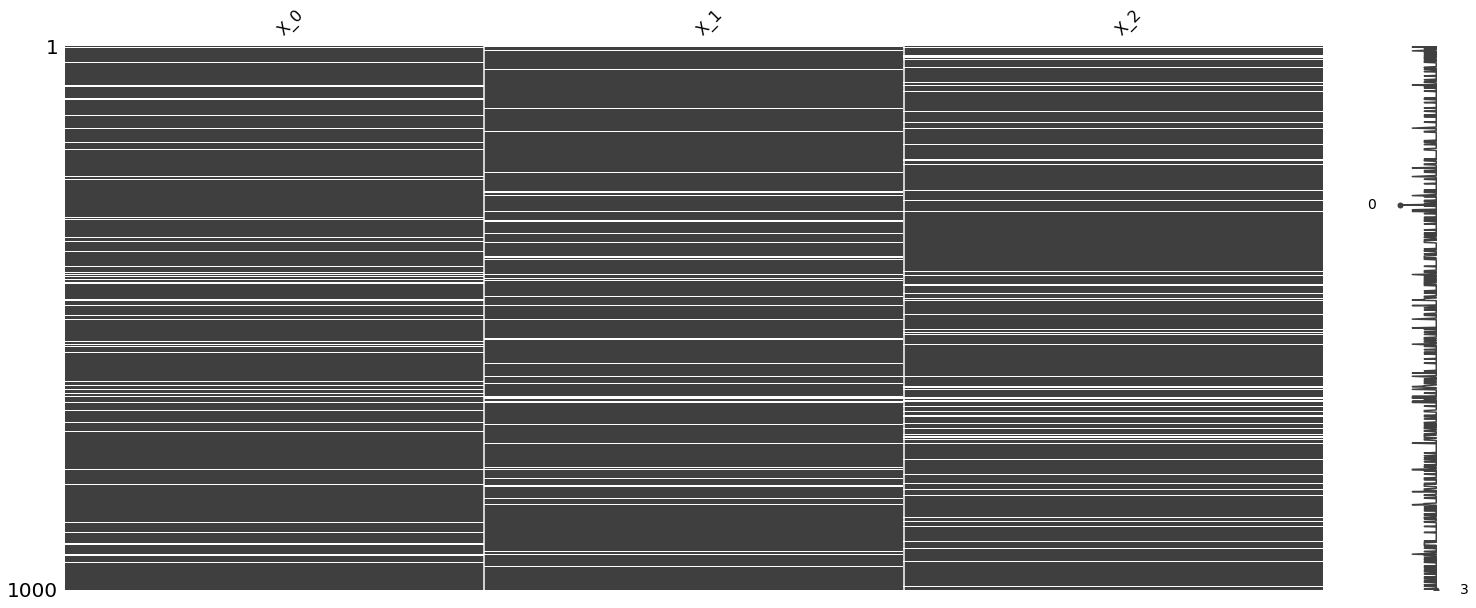

In [5]:
import missingno as msno

_ = msno.matrix(df)

Denote the following.

- N: represents data that is not missing (will be used for training)
- T: represents data that is ground truth for missing data (will be used for validation)
- M: represents data that is missing (will be used for testing)

In [6]:
N_df = df.dropna()
T_df = pd.DataFrame(X[df.isnull().any(axis=1), :], columns=N_df.columns)
M_df = df[df.isnull().any(axis=1)]

N_df.shape, T_df.shape, M_df.shape

((732, 3), (268, 3), (268, 3))

In [7]:
T_df.iloc[0]

X_0   -0.054464
X_1    0.222191
X_2    2.381753
Name: 0, dtype: float64

In [8]:
M_df.iloc[0]

X_0   -0.054464
X_1         NaN
X_2    2.381753
Name: 0, dtype: float64

## Dataset, Data Loader

We will have to create our datasets and data loaders.

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import *

class SampleDataset(Dataset):
    def __init__(self, X, device, clazz=0):
        self.__device = device
        self.__clazz = clazz
        self.__X = X

    def __len__(self):
        return self.__X.shape[0]

    def __getitem__(self, idx):
        item = self.__X[idx,:]
        
        return item, self.__clazz

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

N_ds = SampleDataset(X=N_df.values, device=device)
M_ds = SampleDataset(X=M_df.fillna(0.0).values, device=device)

N_dl = DataLoader(N_ds, batch_size=64, shuffle=True, num_workers=1)
M_dl = DataLoader(M_ds, batch_size=64, shuffle=True, num_workers=1)

cuda


## Autoencoder

The two autoencoder architectures are adopted from the following.

- [AE1](https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/)
- [AE2](https://github.com/Harry24k/MIDA-pytorch/blob/master/MIDA.ipynb)

In [10]:
from torchvision import datasets
from torchvision import transforms

class AE1(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        
        self.input_size = input_size
        self.drop_out = torch.nn.Dropout(p=0.5)
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )
          
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, input_size)
        )
  
    def forward(self, x):
        drop_out = self.drop_out(x)
        encoded = self.encoder(drop_out)
        decoded = self.decoder(encoded)
        return decoded

class AE2(torch.nn.Module):
    def __init__(self, dim, theta=7):
        super().__init__()
        self.dim = dim
        self.theta = theta
        
        self.drop_out = torch.nn.Dropout(p=0.5)
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(dim+theta*0, dim+theta*1),
            torch.nn.Tanh(),
            torch.nn.Linear(dim+theta*1, dim+theta*2),
            torch.nn.Tanh(),
            torch.nn.Linear(dim+theta*2, dim+theta*3)
        )
            
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(dim+theta*3, dim+theta*2),
            torch.nn.Tanh(),
            torch.nn.Linear(dim+theta*2, dim+theta*1),
            torch.nn.Tanh(),
            torch.nn.Linear(dim+theta*1, dim+theta*0)
        )
        
    def forward(self, x):
        x = x.view(-1, self.dim)
        x_missed = self.drop_out(x)
        
        z = self.encoder(x_missed)
        out = self.decoder(z)
        
        out = out.view(-1, self.dim)
        
        return out

## Learning

We will train two autoencoder models and compare how they perform with data imputation.

In [11]:
def train(model, optimizer):
    loss_function = torch.nn.MSELoss()
    
    epochs = 20
    loss_df = []

    for epoch in range(epochs):
        losses = []

        for (items, _) in N_dl:  
            items = items.to(device)
            optimizer.zero_grad()

            reconstructed = model(items)
            loss = loss_function(reconstructed, items)

            loss.backward()

            optimizer.step()

            losses.append(loss.detach().cpu().numpy().item())

        losses = np.array(losses)

        loss_df.append({
            'epoch': epoch + 1,
            'loss': losses.mean()
        })

    loss_df = pd.DataFrame(loss_df)
    loss_df.index = loss_df['epoch']
    loss_df = loss_df.drop(columns=['epoch'])
    
    return loss_df

In [12]:
model_1 = AE1(input_size=N_df.shape[1]).double().to(device)
opt_1 = torch.optim.Adam(model_1.parameters(), lr=1e-3, weight_decay=1e-8)
loss_1 = train(model_1, opt_1)

In [13]:
model_2 = AE2(dim=N_df.shape[1]).double().to(device)
opt_2 = torch.optim.SGD(model_2.parameters(), momentum=0.99, lr=0.01, nesterov=True)

loss_2 = train(model_2, opt_2)

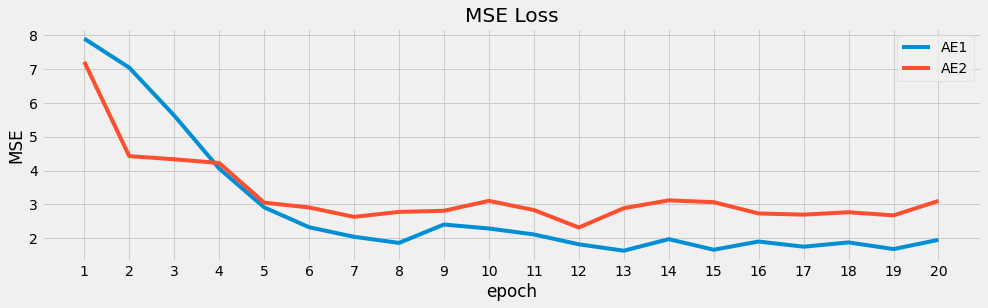

In [14]:
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

ax = loss_1['loss'].plot(kind='line', figsize=(15, 4), title='MSE Loss', ylabel='MSE', label='AE1')
_ = loss_2['loss'].plot(kind='line', figsize=(15, 4), title='MSE Loss', ylabel='MSE', ax=ax, label='AE2')
_ = ax.set_xticks(list(range(1, 21, 1)))
_ = ax.legend()

## Imputation

Now we will impute the data using the two autoencoders. The performance will be the average L2 distance between the imputed and true data.

In [15]:
def predict(m, items, device):
    return m(items.to(device)).cpu().detach().numpy()

def get_imputation(m_v, p_v, t_v):
    def get_value(m, p, t):
        return p if pd.isna(m) else t
    
    return np.array([get_value(m, p, t) for m, p, t in zip(m_v, p_v, t_v)])

def get_performance(model):
    N_pred = np.vstack([predict(model, items, device) for items, _ in N_dl])
    M_pred = np.vstack([predict(model, items, device) for items, _ in M_dl])
    I_pred = np.array([get_imputation(M_df.values[r,:], M_pred[r,:], T_df.values[r,:]) for r in range(M_df.shape[0])])

    n_perf = np.array([np.linalg.norm(N_df.values[r,:] - N_pred[r,:], 2) for r in range(N_df.shape[0])]).mean()
    m_perf = np.array([np.linalg.norm(T_df.values[r,:] - I_pred[r,:], 2) for r in range(T_df.shape[0])]).mean()
    
    return n_perf, m_perf

The first value is the training performance and the second value is the testing/validation performance. Lower is better. The results for the first autoencoder method is shown below.

In [16]:
get_performance(model_1)

(4.419058376740261, 2.0210263067003247)

The results for the second autoencoder method is shown below.

In [17]:
get_performance(model_2)

(4.414670724819407, 1.9455886899656865)